In [ ]:
%pip install PyWavelets

In [ ]:
# Importing packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
import os
import scipy.io
from scipy.signal import butter, filtfilt, find_peaks
#from google.colab import drive
import datetime
import pywt
import seaborn
import keras
import random
import numpy as np
import csv
import requests
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [ ]:

url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/RECORDS'

response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:

    text = response.text
    print("Successfully retrieve the patient Id's Status code:", response.status_code)
else:
    print("Failed to retrieve the text content. Status code:", response.status_code)

lines = text.strip().split('\n')

csv_file = 'record_names.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[line] for line in lines])

print(f'CSV file "{csv_file}" has been created.')


Successfully retrieve the patient Id's Status code: 200
CSV file "record_names.csv" has been created.


In [ ]:

csv_file = 'record_names.csv'

patient_ids_df = pd.read_csv(csv_file, header=None)

patient_ids = patient_ids_df.to_numpy().reshape(-1)

print(patient_ids)

['v100s' 'v101l' 'v102s' 'a103l' 'a104s' 'a105l' 't106s' 't107l' 't108s'
 'a109l' 't110s' 'v111l' 't112s' 'v113l' 't114s' 'v115l' 't116s' 't117l'
 't118s' 'v119l' 'f120s' 'f121l' 'v122s' 'a123l' 'b124s' 'b125l' 'b126s'
 'v127l' 'v128s' 'f129l' 'f130s' 'v131l' 'v132s' 'v133l' 'a134s' 'v135l'
 'v136s' 'f137l' 'f138s' 'v139l' 'v140s' 'v141l' 'a142s' 'v143l' 'f144s'
 'a145l' 'v146s' 'v147l' 'v148s' 't149l' 't150s' 't151l' 'a152s' 'v153l'
 'v154s' 'v155l' 't156s' 't157l' 'v158s' 'v159l' 'v160s' 'a161l' 'v162s'
 'a163l' 'v164s' 'a165l' 'v166s' 'a167l' 'v168s' 'v169l' 'a170s' 'a171l'
 'a172s' 't173l' 't174s' 't175l' 'v176s' 'v177l' 'a178s' 'v179l' 'v180s'
 'v181l' 'v182s' 'b183l' 'b184s' 'a185l' 'a186s' 'b187l' 'v188s' 'f189l'
 'f190s' 't191l' 't192s' 't193l' 'v194s' 't195l' 'f196s' 'v197l' 'v198s'
 'v199l' 'v200s' 'v201l' 'v202s' 'a203l' 'v204s' 'v205l' 'v206s' 'v207l'
 't208s' 't209l' 'v210s' 'v211l' 'v212s' 't213l' 't214s' 'b215l' 'b216s'
 'v217l' 'v218s' 'a219l' 'b220s' 'v221l' 'v222s' 'a

In [ ]:
import os
import requests

def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        print(f"Downloading {url}...")
        r = requests.get(url)
        if r.status_code == 200:
            with open(dest_path, 'wb') as f:
                f.write(r.content)
            print(f"Saved to {dest_path}")
        else:
            print(f"Failed to download {url}. Status code: {r.status_code}")
    else:
        print(f"File already exists: {dest_path}")

def extracting_database(record_name, data_dir='./training'):
    os.makedirs(data_dir, exist_ok=True)

    base_url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/'

    mat_url = f"{base_url}{record_name}.mat"
    hea_url = f"{base_url}{record_name}.hea"

    record_path = os.path.join(data_dir, f"{record_name}.mat")
    hea_file_path = os.path.join(data_dir, f"{record_name}.hea")

    download_file(mat_url, record_path)
    download_file(hea_url, hea_file_path)

    return record_path, hea_file_path


In [ ]:
record_name = 'a103l'
record_path, hea_file_path = extracting_database(record_name)


File already exists: ./training/a103l.mat
File already exists: ./training/a103l.hea


In [ ]:
def extract_pleth_signal(record_path):

    mat_data = scipy.io.loadmat(record_path)

    signals = mat_data['val']

    pleth_signal = signals[2]  # PLETH is the third signal

    return pleth_signal

record_name = 'a103l'
record_path, hea_file_path = extracting_database(record_name)
pleth_signal = extract_pleth_signal(record_path)
pleth_signal

File already exists: ./training/a103l.mat
File already exists: ./training/a103l.hea


array([6042, 6821, 5992, ..., 6454, 6385, 6301], dtype=int16)

In [ ]:
def extract_pleth_info(file_path):

    pleth_info = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

        first_line_info = lines[0].split()
        pleth_info['file_name'] = first_line_info[0]
        pleth_info['num_signals'] = int(first_line_info[1])
        pleth_info['frequency'] = int(first_line_info[2])
        pleth_info['num_samples'] = int(first_line_info[3])

        last_three_lines = lines[-3:]
        pleth_info['ADC_resolution'] = last_three_lines[0].split()[1]
        pleth_info['ADC_gain'] = last_three_lines[0].split()[2]
        pleth_info['ADC_bits'] = int(last_three_lines[0].split()[3])
        pleth_info['ADC_zero'] = int(last_three_lines[0].split()[4])
        pleth_info['initial_value'] = int(last_three_lines[0].split()[5])
        pleth_info['check_sum'] = int(last_three_lines[0].split()[6])
        pleth_info['block_size'] = int(last_three_lines[0].split()[7])
        pleth_info['description'] = last_three_lines[0].split()[8]
        pleth_info['electrical_activity'] = last_three_lines[1].replace("#", "").replace("\n", "")
        pleth_info['validity'] = last_three_lines[2].replace("#", "").replace("\n", "")
        return pleth_info

file_path = hea_file_path
pleth_info = extract_pleth_info(file_path)
pleth_info

{'file_name': 'a103l',
 'num_signals': 3,
 'frequency': 250,
 'num_samples': 82500,
 'ADC_resolution': '16+24',
 'ADC_gain': '1.253e+04/NU',
 'ADC_bits': 16,
 'ADC_zero': 0,
 'initial_value': 6042,
 'check_sum': -17391,
 'block_size': 0,
 'description': 'PLETH',
 'electrical_activity': 'Asystole',
 'validity': 'False alarm'}

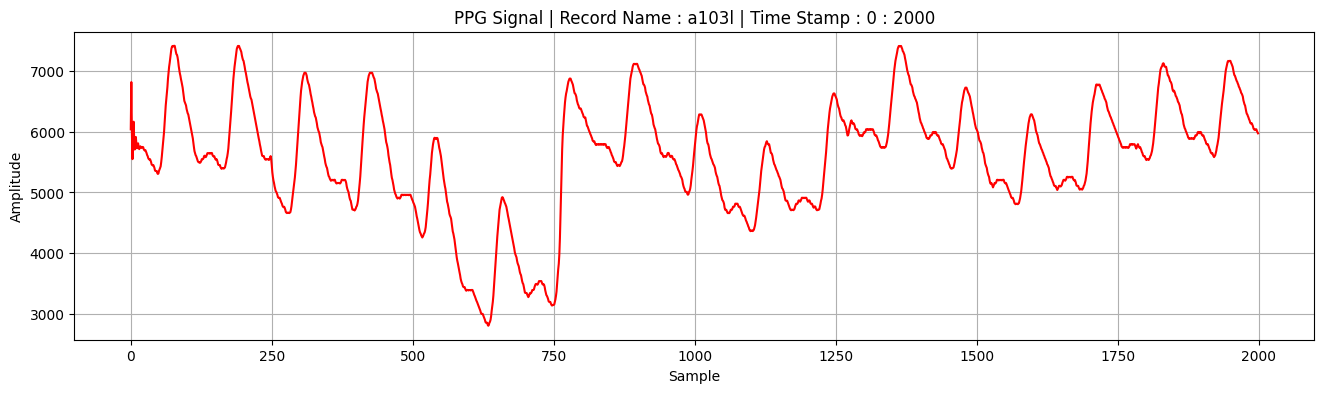

In [ ]:

InitialTime = 0
FinalTime = 2000
plt.figure(figsize=(16, 4))
plt.plot(pleth_signal[InitialTime : FinalTime], color='red')
plt.title('PPG Signal | Record Name : ' + str(record_name) +" | Time Stamp : "+ str(InitialTime) + " : " + str(FinalTime))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
pleth_infos = {}
pleth_signals = {}

count = len(patient_ids)
i = 0
for patient_id in patient_ids:

    # Download the files and get their paths
    record_path, hea_file_path = extracting_database(patient_id)

    print("Signal of patient " + str(patient_id) + " extracted")

    # Extract PLETH signal
    pleth_signal = extract_pleth_signal(record_path)
    pleth_signals[patient_id] = pleth_signal

    print("PPG of patient " + str(patient_id) + " loaded")

    # Extract PLETH information
    pleth_info = extract_pleth_info(hea_file_path)
    pleth_infos[patient_id] = pleth_info

    print("Info of patient " + str(patient_id) + " loaded")

    print("PPG and info extracted for " + str(i+1) + " and " + str(count - i - 1) + " left.")

    i += 1


File already exists: ./training/v100s.mat
File already exists: ./training/v100s.hea
Signal of patient v100s extracted
PPG of patient v100s loaded
Info of patient v100s loaded
PPG and info extracted for 1 and 749 left.
File already exists: ./training/v101l.mat
File already exists: ./training/v101l.hea
Signal of patient v101l extracted
PPG of patient v101l loaded
Info of patient v101l loaded
PPG and info extracted for 2 and 748 left.
File already exists: ./training/v102s.mat
File already exists: ./training/v102s.hea
Signal of patient v102s extracted
PPG of patient v102s loaded
Info of patient v102s loaded
PPG and info extracted for 3 and 747 left.
File already exists: ./training/a103l.mat
File already exists: ./training/a103l.hea
Signal of patient a103l extracted
PPG of patient a103l loaded
Info of patient a103l loaded
PPG and info extracted for 4 and 746 left.
File already exists: ./training/a104s.mat
File already exists: ./training/a104s.hea
Signal of patient a104s extracted
PPG of pat

In [ ]:
pleth_infos[str(patient_ids[400])]


{'file_name': 'f500s',
 'num_signals': 4,
 'frequency': 250,
 'num_samples': 75000,
 'ADC_resolution': '16+24',
 'ADC_gain': '47.8/mmHg',
 'ADC_bits': 16,
 'ADC_zero': 0,
 'initial_value': 4912,
 'check_sum': 23760,
 'block_size': 0,
 'description': 'ABP',
 'electrical_activity': 'Ventricular_Flutter_Fib',
 'validity': 'False alarm'}

In [ ]:
unique_frequencies = set()

for signal_data in pleth_infos.values():
    unique_frequencies.add(signal_data['frequency'])

print("Unique sample frequencies:", unique_frequencies)

Unique sample frequencies: {250}


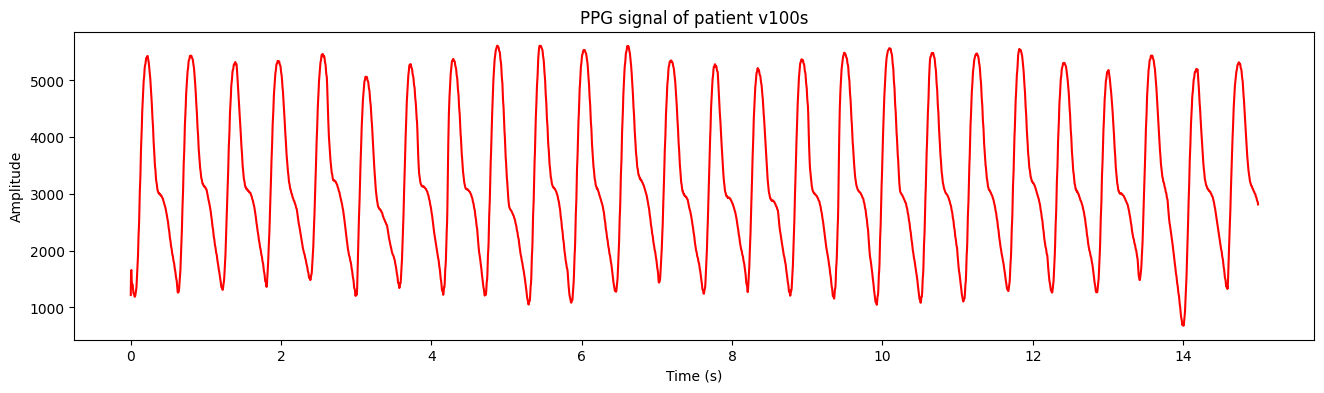

In [ ]:
def plot_ppg_signal(patient_id, starting_time, ending_time):
    pleth_info = pleth_infos[str(patient_id)]
    sampling_frequency = pleth_info['frequency']

    starting_signal_point = int(starting_time * sampling_frequency)
    ending_signal_point = int(ending_time * sampling_frequency)

    x = np.arange(starting_time, ending_time, 1 / sampling_frequency)

    signal = pleth_signals[str(patient_id)][starting_signal_point:ending_signal_point]

    plt.figure(figsize=(16, 4))
    plt.plot(x, signal, color='red')
    plt.title(f'PPG signal of patient {patient_id}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

plot_ppg_signal(patient_ids[0], 0, 15)


In [ ]:
def bandpass_filter(signal, lowcut, highcut, fs):

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    order = 3  # Filter order
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def remove_baseline_wandering(signal):
    if len(signal.shape) != 1 or len(signal) == 0:
        raise ValueError("Input signal must be a non-empty 1D array.")

    wavelet = 'sym8'
    level = 4
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Zero out the detail coefficients
    coeffs = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]

    reconstructed_signal = pywt.waverec(coeffs, wavelet)
    reconstructed_signal = reconstructed_signal[:len(signal)]  # Safety crop
    return reconstructed_signal

from scipy.signal import savgol_filter

def savitzky_golay(signal, window_length=21, polyorder=3):
    if len(signal) < window_length:
        window_length = len(signal) if len(signal) % 2 == 1 else len(signal) - 1
    if window_length < polyorder + 2:
        window_length = polyorder + 2
    if window_length % 2 == 0:
        window_length += 1  # window_length harus ganjil
    if len(signal) < window_length:
        return signal  # kalau masih kependekan, balikin signal original saja

    smoothed = savgol_filter(signal, window_length, polyorder)
    return smoothed

def normalize_signal(signal):

    normalized_signal = (signal - np.mean(signal)) / np.std(signal)
    return normalized_signal

In [ ]:

def segment_signal(signal, segment_length, fs):

    num_samples_per_segment = int(segment_length * fs)
    num_segments = len(signal) // num_samples_per_segment
    segmented_signal = [signal[i * num_samples_per_segment: (i + 1) * num_samples_per_segment]
                        for i in range(num_segments)]
    return segmented_signal

In [ ]:
fs = pleth_info['frequency']
segmented_signal = segment_signal(pleth_signal, 15, fs)

processed_segments = []

for segment in segmented_signal:
    segment_processed = bandpass_filter(segment, lowcut=0.4, highcut=30, fs=fs)


    window_length = min(51, len(segment_processed) if len(segment_processed) % 2 == 1 else len(segment_processed) - 1)
    polyorder = 3
    segment_processed = savitzky_golay(segment_processed, window_length, polyorder)

    if segment_processed is not None and len(segment_processed.shape) == 1 and len(segment_processed) > 0:
        segment_processed = remove_baseline_wandering(segment_processed)
    else:
        print(f"Skipping baseline removal, segment shape: {segment_processed.shape if segment_processed is not None else 'None'}")

    segment_processed = normalize_signal(segment_processed)
    processed_segments.append(segment_processed)

In [ ]:
def plot_ppg_signal_sampled(pleth_signal, fs, starting_time, ending_time):

    starting_signal_point = int(starting_time * fs)
    ending_signal_point = int(ending_time * fs)

    x = np.arange(starting_time, ending_time, 1 / fs)

    signal = pleth_signal[starting_signal_point:ending_signal_point]

    plt.figure(figsize=(16, 4))
    plt.plot(x, signal, color='red')
    plt.title(f'PPG signal of patient')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

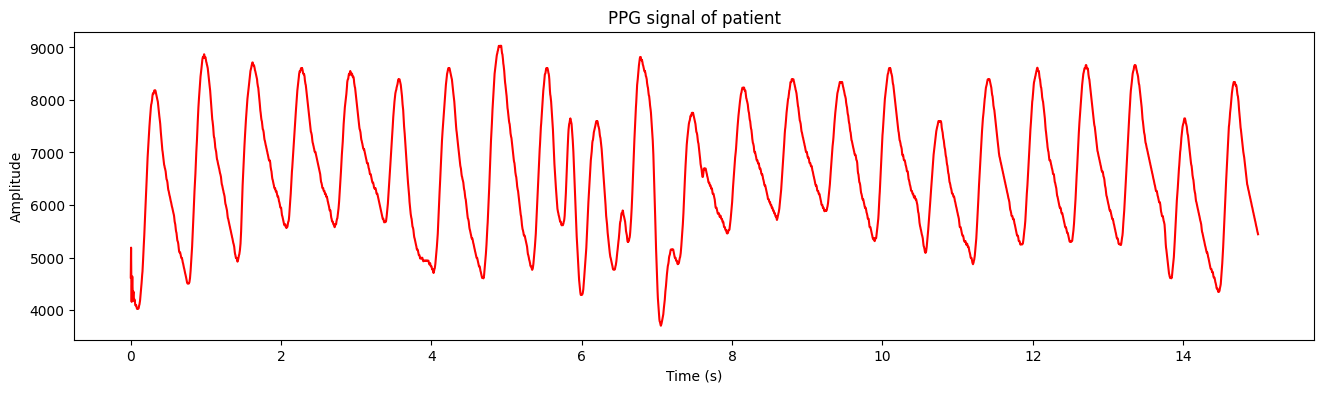

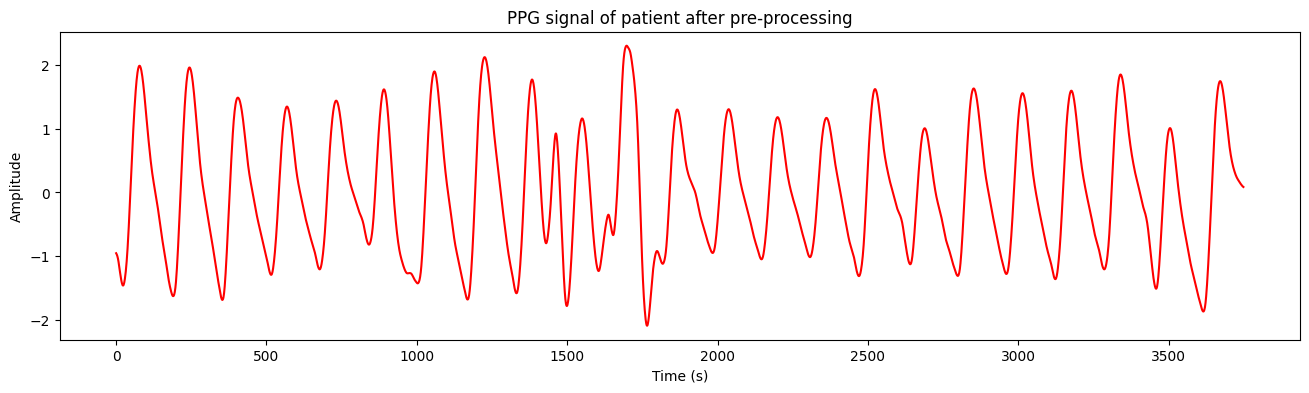

In [ ]:
plot_ppg_signal_sampled(pleth_signal, fs, 0, 15)

plt.figure(figsize=(16, 4))
plt.plot(processed_segments[0], color='red')
plt.title(f'PPG signal of patient after pre-processing')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
#Features
def calculate_pulse_width(peak_window, fs):
    pw = len(peak_window) / fs
    return pw

def calculate_fwhm(peak_window, fs):
    max_index = np.argmax(peak_window)
    half_max = peak_window[max_index] / 2
    left_indices = np.where(peak_window[:max_index] <= half_max)[0]
    right_indices = np.where(peak_window[max_index:] <= half_max)[0] + max_index
    if len(left_indices) == 0 or len(right_indices) == 0:
        return 0

    left_index = left_indices[-1]
    right_index = right_indices[0]
    fwhm = (right_index - left_index) / fs

    return fwhm

def detect_prominent_peaks(ppg_signal, fs, prominence=0.5):
    # Calculate the peak height threshold based on a percentage of the maximum amplitude
    peak_height_threshold = prominence * np.max(ppg_signal)

    # Find peaks above the threshold
    peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold)

    ## Plot the PPG signal with detected peaks for visualization
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(ppg_signal)) / fs, ppg_signal, label='PPG signal')
    plt.plot(peaks / fs, ppg_signal[peaks], 'ro', label='Detected Prominent Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('PPG Signal with Detected Prominent Peaks')
    plt.legend()
    plt.grid(True)
    plt.show()

    return peaks


In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.fft import fft
from scipy import stats
from scipy.integrate import trapezoid

# Morphological Features function
def extract_morphological_features(peak_window, peak_index, fs):
    sa = np.max(peak_window)
    Da = np.min(peak_window)
    SA = trapezoid(peak_window, dx=1/fs)
    DA = trapezoid(peak_window, dx=1/fs) - SA
    signal_area = trapezoid (peak_window, dx=1/fs)
    St = peak_index / fs
    Dt = (len(peak_window) - peak_index) / fs
    return sa, Da, SA, DA, St, Dt

# Frequency Domain Features function
def extract_frequency_features(peak_window, fs):
    fft_result = fft(peak_window)
    magnitude_spectrum = np.abs(fft_result)
    frequency_spectrum = np.fft.fftfreq(len(peak_window), d=1/fs)
    dominant_frequency = frequency_spectrum[np.argmax(magnitude_spectrum)]
    pmf = magnitude_spectrum / np.sum(magnitude_spectrum)
    spectral_entropy = -np.sum(pmf * np.log2(pmf + 1e-10))
    return dominant_frequency, spectral_entropy

# Statistical Features function
def extract_statistical_features(peak_window):
    mean = np.mean(peak_window)
    median = np.median(peak_window)
    std_deviation = np.std(peak_window)
    skewness = stats.skew(peak_window)
    kurtosis = stats.kurtosis(peak_window)
    min_value = np.min(peak_window)
    max_value = np.max(peak_window)
    variance = np.var(peak_window)
    return mean, median, std_deviation, skewness, kurtosis, min_value, max_value, variance

# Additional Features function
def extract_additional_features(peak_window, peak_index, fs, prev_peak_index):
    ppi = (peak_index - prev_peak_index) / fs if prev_peak_index is not None else 0
    pw = calculate_pulse_width(peak_window, fs)
    fwhm = calculate_fwhm(peak_window, fs)
    signal_area = np.trapz(peak_window, dx=1/fs)
    rise_time = peak_index / fs - max(0, peak_index - int(fs * 2)) / fs
    fall_time = (len(peak_window) - peak_index) / fs
    amplitude_modulation_depth = np.max(peak_window) - np.min(peak_window)
    energy = np.sum(peak_window ** 2)
    zero_crossing_rate = calculate_zero_crossing_rate(peak_window)
    return ppi, pw, fwhm, signal_area, rise_time, fall_time, amplitude_modulation_depth, energy, zero_crossing_rate

# Feature calculation functions
def calculate_pulse_width(peak_window, fs):
    half_max = 0.5 * np.max(peak_window)
    above_half = peak_window >= half_max
    crossings = np.where(above_half)[0]
    if len(crossings) < 2:
        return 0.0
    return (crossings[-1] - crossings[0]) / fs

def calculate_fwhm(peak_window, fs):
    half_max = 0.5 * np.max(peak_window)
    cross_indices = np.where(peak_window >= half_max)[0]
    if len(cross_indices) == 0:
        return 0.0
    return (cross_indices[-1] - cross_indices[0]) / fs

def calculate_zero_crossing_rate(signal):
    return np.sum(np.diff(np.sign(signal)) != 0) / len(signal)

# Main function to extract all features
def extract_ppg_features(ppg_signal, fs):
    peak_height_threshold = 0.5 * (np.percentile(ppg_signal, 75) + np.median(ppg_signal))
    peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold)

    peak_features = []
    prev_peak_index = None

    for peak_index in peaks:
        window_size = int(fs * 2)
        peak_window = ppg_signal[max(0, peak_index - window_size):min(len(ppg_signal), peak_index + window_size)]

        # Extract Morphological Features
        sa, Da, SA, DA, St, Dt = extract_morphological_features(peak_window, peak_index, fs)

        # Extract Frequency Domain Features
        dominant_frequency, spectral_entropy = extract_frequency_features(peak_window, fs)

        # Extract Statistical Features
        mean, median, std_deviation, skewness, kurtosis, min_value, max_value, variance = extract_statistical_features(peak_window)

        # Extract Additional Features
        ppi, pw, fwhm, signal_area, rise_time, fall_time, amplitude_modulation_depth, energy, zero_crossing_rate = extract_additional_features(peak_window, peak_index, fs, prev_peak_index)

        # Append features to the list
        peak_features.append({
            'sa': sa, 'Da': Da, 'SA': SA, 'DA': DA, 'St': St, 'Dt': Dt,
            'Dominant_frequency': dominant_frequency, 'Spectral_entropy': spectral_entropy,
            'Mean': mean, 'Median': median, 'Standard_deviation': std_deviation, 'Skewness': skewness, 'Kurtosis': kurtosis,
            'Min_value': min_value, 'Max_value': max_value, 'Variance': variance,
            'PPI': ppi, 'Pulse_width': pw, 'FWHM': fwhm, 'Signal_area': signal_area,
            'Rise_time': rise_time, 'Fall_time': fall_time, 'Amplitude_modulation_depth': amplitude_modulation_depth,
            'Energy': energy, 'Zero_crossing_rate': zero_crossing_rate
        })

        prev_peak_index = peak_index

    return peak_features, peaks


<ipython-input-142-b6657543a35e>:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  signal_area = np.trapz(peak_window, dx=1/fs)


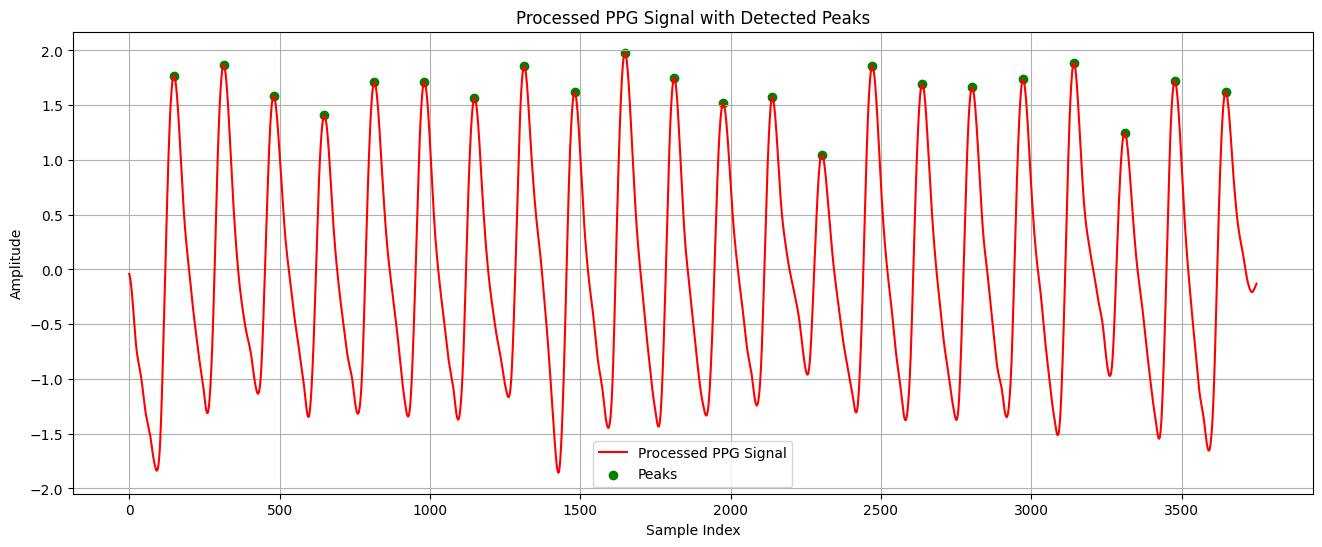

In [ ]:
# Assuming `extract_ppg_features` returns peak features and peak points
features, peaks = extract_ppg_features(processed_segments[6], fs)

# Plot the processed PPG signal
plt.figure(figsize=(16, 6))
plt.plot(processed_segments[6], label='Processed PPG Signal', color='red')

# Plot the detected peaks
plt.scatter(peaks, processed_segments[6][peaks], color='green', label='Peaks')

plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Processed PPG Signal with Detected Peaks')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
features, peaks = extract_ppg_features(processed_segments[0],fs)

<ipython-input-142-b6657543a35e>:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  signal_area = np.trapz(peak_window, dx=1/fs)


In [ ]:
features

[{'sa': np.float64(1.9846447035266814),
  'Da': np.float64(-1.683318719558898),
  'SA': np.float64(0.03074682833916384),
  'DA': np.float64(0.0),
  'St': np.float64(0.312),
  'Dt': np.float64(2.0),
  'Dominant_frequency': np.float64(1.7301038062283738),
  'Spectral_entropy': np.float64(6.695221522473135),
  'Mean': np.float64(0.013527082938965313),
  'Median': np.float64(-0.10165378863946231),
  'Standard_deviation': np.float64(1.1046798971206333),
  'Skewness': np.float64(0.20516917808427335),
  'Kurtosis': np.float64(-1.2650036849052513),
  'Min_value': np.float64(-1.683318719558898),
  'Max_value': np.float64(1.9846447035266814),
  'Variance': np.float64(1.220317675102453),
  'PPI': 0,
  'Pulse_width': np.float64(2.076),
  'FWHM': np.float64(2.076),
  'Signal_area': np.float64(0.03074682833916384),
  'Rise_time': np.float64(0.312),
  'Fall_time': np.float64(2.0),
  'Amplitude_modulation_depth': np.float64(3.6679634230855793),
  'Energy': np.float64(705.4493797895177),
  'Zero_crossi

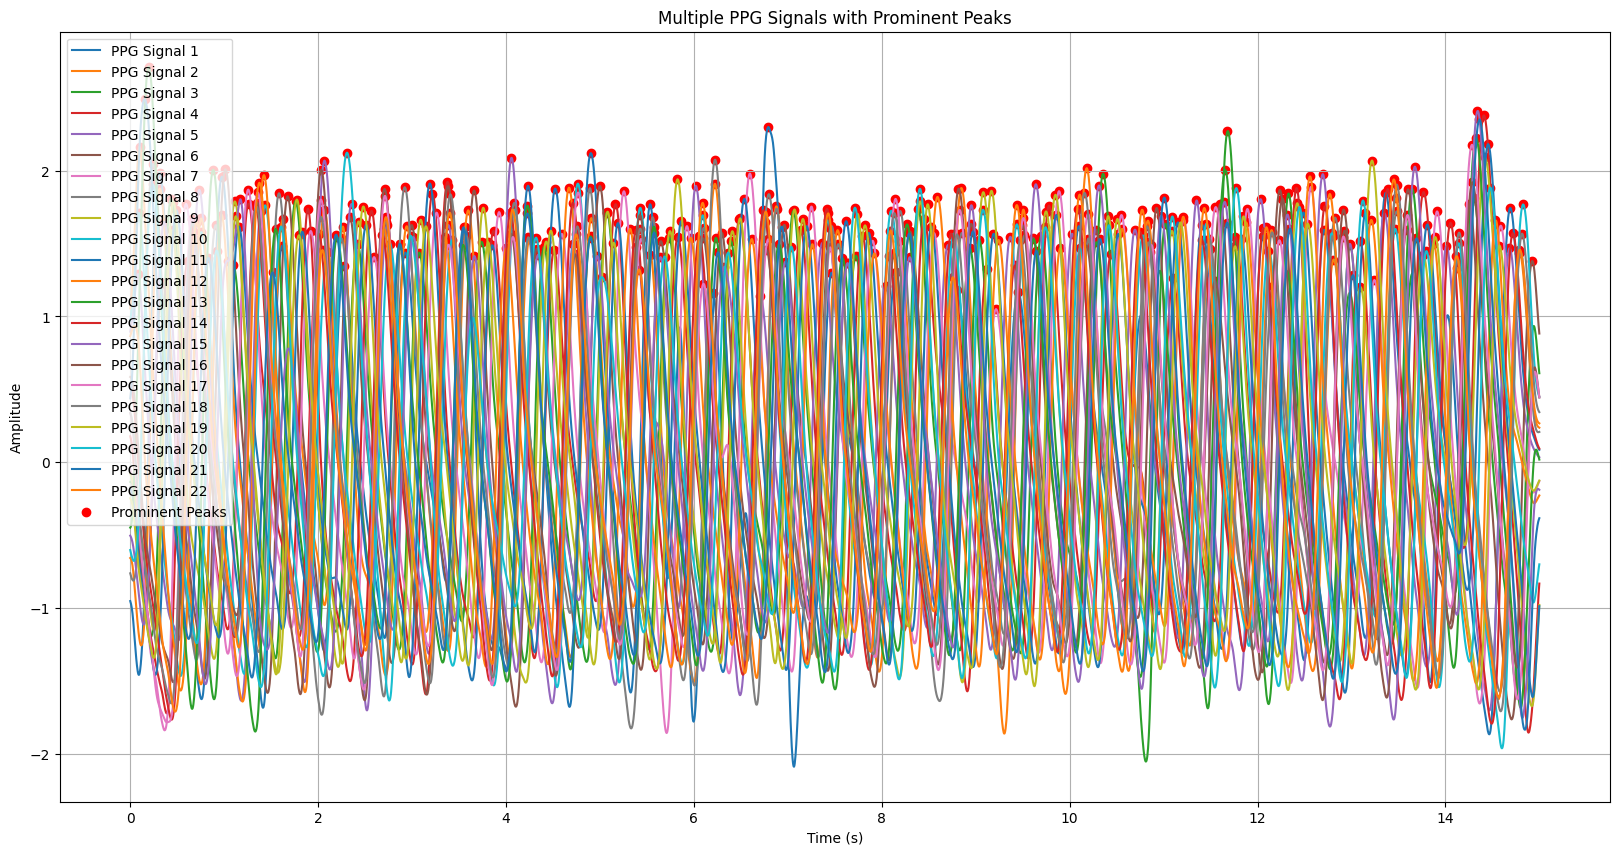

In [ ]:
def plot_multiple_ppg_with_peaks(ppg_signals, fs):
    plt.figure(figsize=(20, 10))
    all_peaks = []  # List to store all prominent peaks

    for i, ppg_signal in enumerate(ppg_signals):
        duration = len(ppg_signal) / fs
        time = np.linspace(0, duration, len(ppg_signal))

        plt.plot(time, ppg_signal, label=f'PPG Signal {i+1}')

        # Detect prominent peaks in the current PPG signal
        peak_height_threshold = 0.5 * np.max(ppg_signal)  # Adjust the threshold as needed
        peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold)
        all_peaks.append(peaks)  # Store the peaks for all signals

    # Plot all prominent peaks together
    all_peaks_flat = [peak / fs for peaks in all_peaks for peak in peaks]
    all_peaks_amplitudes = [ppg_signal[peak] for peaks, ppg_signal in zip(all_peaks, ppg_signals) for peak in peaks]
    plt.scatter(all_peaks_flat, all_peaks_amplitudes, color='red', label='Prominent Peaks')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Multiple PPG Signals with Prominent Peaks')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_multiple_ppg_with_peaks(processed_segments,fs)

In [ ]:
electrical_activity_counts = {}

for patient_info in pleth_infos.values():
    electrical_activity = patient_info.get('electrical_activity')
    electrical_activity_counts[electrical_activity] = electrical_activity_counts.get(electrical_activity, 0) + 1
print("Unique electrical activities and their counts:")
for activity, count in electrical_activity_counts.items():
    print(f"{activity}: {count}")

Unique electrical activities and their counts:
Ventricular_Tachycardia: 341
Asystole: 122
Tachycardia: 140
Ventricular_Flutter_Fib: 58
Bradycardia: 89


In [ ]:
# Initialize a dictionary to store patient IDs for each unique electrical activity
patient_ids_by_activity = {}

# Iterate through the nested dictionaries in pleth_infos
for patient_id, patient_info in pleth_infos.items():
    # Extract the electrical activity for the current patient
    electrical_activity = patient_info.get('electrical_activity')
    # Extract the validity of the electrical activity
    validity = patient_info.get('validity')

    # Check if the validity is 'True alarm'
    if validity == 'True alarm':
        # Add the patient ID to the list associated with the electrical activity
        if electrical_activity:
            if electrical_activity not in patient_ids_by_activity:
                patient_ids_by_activity[electrical_activity] = []
            patient_ids_by_activity[electrical_activity].append(patient_id)

# Print the list of patient IDs for each unique electrical activity
print("List of patient IDs for each unique electrical activity with validity 'True alarm':")
for activity, patient_ids in patient_ids_by_activity.items():
    print(f"{activity}: {patient_ids}")


List of patient IDs for each unique electrical activity with validity 'True alarm':
Tachycardia: ['t106s', 't107l', 't108s', 't110s', 't112s', 't114s', 't117l', 't118s', 't149l', 't150s', 't151l', 't156s', 't157l', 't173l', 't174s', 't175l', 't191l', 't192s', 't193l', 't195l', 't208s', 't209l', 't213l', 't214s', 't234s', 't235l', 't238s', 't240s', 't249l', 't251l', 't252s', 't263l', 't264s', 't270s', 't276s', 't277l', 't284s', 't300s', 't305l', 't320s', 't333l', 't335l', 't342s', 't343l', 't344s', 't350s', 't351l', 't356s', 't357l', 't358s', 't393l', 't394s', 't406s', 't410s', 't411l', 't412s', 't413l', 't416s', 't417l', 't418s', 't424s', 't425l', 't430s', 't434s', 't444s', 't445l', 't447l', 't458s', 't467l', 't468s', 't477l', 't478s', 't506s', 't507l', 't508s', 't509l', 't520s', 't521l', 't524s', 't546s', 't547l', 't565l', 't567l', 't577l', 't580s', 't589l', 't594s', 't595l', 't614s', 't622s', 't662s', 't665l', 't677l', 't678s', 't679l', 't680s', 't683l', 't688s', 't689l', 't690s', 't

In [ ]:
max_length = 6

for key, arr in patient_ids_by_activity.items():
    if len(arr) > max_length:
        patient_ids_by_activity[key] = arr[:max_length]


In [ ]:
def apply_pca(features, n_components=10):
    pca = PCA(n_components=n_components)
    scaled_features = StandardScaler().fit_transform(features)  # Scale features before PCA
    pca_features = pca.fit_transform(scaled_features)
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio by each component: {explained_variance}")
    cumulative_variance = explained_variance.cumsum()
    print(f"Cumulative Explained Variance: {cumulative_variance}")
    return pca_features, cumulative_variance


In [ ]:
# Dataset creation and processing
dataset = []
i = 0
for label, patient_ids in patient_ids_by_activity.items():
    for patient_id in patient_ids:
        if patient_id not in pleth_signals:
            print(f"Patient ID {patient_id} not found in pleth_signal dictionary")
            continue
        fs = pleth_infos[patient_id]['frequency']
        segmented_signal = segment_signal(pleth_signals[patient_id], 10, fs)

        for segment in segmented_signal:
            segment_processed = bandpass_filter(segment, lowcut=0.4, highcut=30, fs=fs)

            window_length = min(51, len(segment_processed) if len(segment_processed) % 2 == 1 else len(segment_processed) - 1)
            polyorder = 3
            segment_processed = savitzky_golay(segment_processed, window_length, polyorder)

            if segment_processed is not None and len(segment_processed.shape) == 1 and len(segment_processed) > 0:
                segment_processed = remove_baseline_wandering(segment_processed)
            else:
                print(f"Skipping baseline removal, segment shape: {segment_processed.shape if segment_processed is not None else 'None'}")

            segment_processed = normalize_signal(segment_processed)

            dataset.append((label, segment_processed))

            features, peaks = extract_ppg_features(segment_processed, fs)
            for feature in features:
                peak_array = [feature[key] for key in feature.keys()]
                dataset.append((label, peak_array))
                i += 1

<ipython-input-142-b6657543a35e>:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  signal_area = np.trapz(peak_window, dx=1/fs)
<ipython-input-136-5156e66548fc>:43: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.mean(signal)) / np.std(signal)


In [ ]:
print(f"Total segments processed: {len(dataset)}")
print(f"Total features processed: {i}")

Total segments processed: 14370
Total features processed: 13422


In [ ]:
labels = [label for label, _ in dataset]
signals = [signal for _, signal in dataset]

In [ ]:
# One-hot encode the labels
unique_labels = set(labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}
encoded_labels = [to_categorical(label_to_index[label], num_classes=len(unique_labels)) for label in labels]

In [ ]:

# Prepare input sequences
# Assuming each signal is of fixed length and you want to pad them to a maximum length
max_length = max(len(signal) for signal in signals)
padded_signals = [np.pad(signal, (0, max_length - len(signal))) for signal in signals]
# Convert to numpy arrays
X = np.array(padded_signals)
y = np.array(encoded_labels)
# Split data into train and test sets (replace with your actual splitting logic)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Reshape Model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Define input shape
input_shape = X_train.shape[1:]  # Shape of input features

# Define number of classes
num_classes = len(unique_labels)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input

# Create LSTM model with ANN after LSTM
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  # Define input layer here
        LSTM(64, return_sequences=True),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),  # Adding ANN layer after LSTM
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create BiLSTM model with ANN after BiLSTM
def create_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  # Define input layer here
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),  # Adding ANN layer after BiLSTM
        Dense(num_classes, activation='softmax')
    ])
    return model

# Model Creation
input_shape = X_train.shape[1:]  # Shape of input features
num_classes = len(unique_labels)

lstm_model = create_lstm_model(input_shape, num_classes)
bilstm_model = create_bilstm_model(input_shape, num_classes)

# Compile the models
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()
bilstm_model.summary()

In [ ]:

# Train the models
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Model evaluation
lstm_evaluation = lstm_model.evaluate(X_test, y_test)
bilstm_evaluation = bilstm_model.evaluate(X_test, y_test)
print("LSTM+ANN Evaluation:", lstm_evaluation)
print("BiLSTM+ANN Evaluation:", bilstm_evaluation)

# Save models
lstm_model.save('/Classification_PPG/lstmmodel.h5')
bilstm_model.save('/Classification_PPG/bilstmmodel.h5')


In [ ]:
lstm_predictions_train = lstm_model.predict(X_train)
bilstm_predictions_train = bilstm_model.predict(X_train)

# Convert predictions to class labels
lstm_pred_labels_train = np.argmax(lstm_predictions_train, axis=1)
bilstm_pred_labels_train = np.argmax(bilstm_predictions_train, axis=1)



In [ ]:
lstm_predictions = lstm_model.predict(X_test)
bilstm_predictions = bilstm_model.predict(X_test)

# Convert predictions to class labels
lstm_pred_labels = np.argmax(lstm_predictions, axis=1)
bilstm_pred_labels = np.argmax(bilstm_predictions, axis=1)

In [ ]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [ ]:
# Define class labels (the unique labels for the classification task)
class_labels = [ 'Bradycardia'  ,  'Asystole', 'V. Flutter Fib',  'V. Tachycardia' ,'Tachycardia']

In [ ]:
# Plotting the training and testing accuracy/loss
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2)

# LSTM Accuracy and Loss
ax[0].plot(epochs, history_lstm_ann.history['loss'], label='Training Loss')
ax[0].plot(epochs, history_lstm_ann.history['val_loss'], label='Testing Loss')
ax[0].set_title('LSTM Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylim(0, 1)

ax[1].plot(epochs, history_lstm_ann.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history_lstm_ann.history['val_accuracy'], label='Testing Accuracy')
ax[1].set_title('LSTM Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylim(0, 1)

plt.show()

In [ ]:

# BiLSTMAccuracy and Loss
fig, ax = plt.subplots(1, 2)

ax[0].plot(epochs, history_bilstm_ann.history['loss'], label='Training Loss')
ax[0].plot(epochs, history_bilstm_ann.history['val_loss'], label='Testing Loss')
ax[0].set_title('BiLSTM Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylim(0, 1)

ax[1].plot(epochs, history_bilstm_ann.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history_bilstm_ann.history['val_accuracy'], label='Testing Accuracy')
ax[1].set_title('BiLSTM Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylim(0, 1)

plt.show()

In [ ]:

# Confusion Matrix and Final Evaluation
lstm_predictions = lstm_ann_model.predict(X_test)
bilstm_predictions = bilstm_ann_model.predict(X_test)

lstm_pred_labels = np.argmax(lstm_predictions, axis=1)
bilstm_pred_labels = np.argmax(bilstm_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# Confusion Matrix for LSTM+ANN and BiLSTM+ANN
conf_matrix_lstm_ann = confusion_matrix(y_test_labels, lstm_pred_labels)
conf_matrix_bilstm_ann = confusion_matrix(y_test_labels, bilstm_pred_labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_lstm_ann, annot=True, fmt='d', cmap='Blues', ax=ax[0], xticklabels=class_labels, yticklabels=class_labels)
ax[0].set_title('Confusion Matrix - LSTM+ANN')

sns.heatmap(conf_matrix_bilstm_ann, annot=True, fmt='d', cmap='Blues', ax=ax[1], xticklabels=class_labels, yticklabels=class_labels)
ax[1].set_title('Confusion Matrix - BiLSTM+ANN')

plt.show()


In [ ]:

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, lstm_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
seaborn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_labels,
                yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Untrained Data) - LSTM Model')
plt.show()



In [ ]:
# Calculate True Positives, True Negatives, False Positives, and False Negatives
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Accuracy (Untrained Dataset):", accuracy)
print("Sensitivity (Untrained Dataset):", sensitivity)
print("Specificity (Untrained Dataset):", specificity)


In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, bilstm_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
seaborn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Untrained Data) - BLSTM Model')
plt.show()



In [ ]:
# Calculate True Positives, True Negatives, False Positives, and False Negatives
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Accuracy (Untrained Dataset):", accuracy)
print("Sensitivity (Untrained Dataset):", sensitivity)
print("Specificity (Untrained Dataset):", specificity)


In [ ]:

# Compute confusion matrix
conf_matrix_train = confusion_matrix(y_train_labels, lstm_pred_labels_train)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
seaborn.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Trained Data) - LSTM Model')
plt.show()

In [ ]:

# Calculate True Positives, True Negatidef collectInput(self):

TP = conf_matrix_train[1, 1]
TN = conf_matrix_train[0, 0]
FP = conf_matrix_train[0, 1]
FN = conf_matrix_train[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Accuracy (Trained Dataset):", accuracy)
print("Sensitivity (Trained Dataset):", sensitivity)
print("Specificity (Trained Dataset):", specificity)

In [ ]:

# Calculate True Positives, True Negatidef collectInput(self):

TP = conf_matrix_train[1, 1]
TN = conf_matrix_train[0, 0]
FP = conf_matrix_train[0, 1]
FN = conf_matrix_train[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Accuracy (Trained Dataset):", accuracy)
print("Sensitivity (Trained Dataset):", sensitivity)
print("Specificity (Trained Dataset):", specificity)

In [ ]:
# Assuming you have already trained your model
lstm_model_test = keras.models.load_model('/Classification_PPG/lstmmodel.h5')
bilstm_model_test = keras.models.load_model('/Classification_PPG/bilstmmodel.h5')

In [ ]:
data = dataset[random.randint(0,len(dataset))]

input = data[1]
label = data[0]

print(label , input)

In [ ]:
input_data = np.array(input).reshape(1, 31, 1)

raw_predictions = lstm_model_test.predict(input_data)

predicted_label_index = np.argmax(raw_predictions)
predicted_percentage = raw_predictions[0][predicted_label_index]

class_labels = [ 'Bradycardia' , 'Asystole', 'Ventricular Flutter Fib', 'Ventricular Tachycardia' ,'Tachycardia']
predicted_label = class_labels[predicted_label_index]

prediction_dict = {}
for label, raw_prediction in zip(class_labels, raw_predictions[0]):
    prediction_dict[label] = f"{raw_prediction*100}%"

prediction_dict